### Author: Nathaniel Ruhl
### Last Updated: 1/8/2021
### Description: This notebook calculates ISS position in 3 ways, 2 of which utilize a change of basis. All three methods require that we know the pole unit vector, and each method requires other knowns.

In [1]:
from astropy.table import Table
import numpy as np
from scipy import interpolate
from astropy.io import ascii
import matplotlib.pyplot as plt
import datetime

# Time range around the horizon crossing
startTime = 390+1.92224*10**8
stopTime = 500+1.92224*10**8

# indices for the event file
startTimeIndex = 311883
stopTimeIndex = 352360

#mkf index
startMKF = 2264
stopMKF = 2374

omegaCalc = 0.001267
RorbitCalc = 6796.4

# read in the data files
tab_ni = Table.read('ni2200300102.mkf', hdu=1)
timeMKF = np.array(tab_ni['TIME'])
elevMKF = np.array(tab_ni['ELV'])
ramMKF = np.array(tab_ni['RAM_ANGLE'])
location = tab_ni['POSITION']
location_mag = np.array(np.sqrt((location[:,0])**2+(location[:,1])**2+(location[:,2])**2))
velocity = tab_ni['VELOCITY']
locationX = location[:,0]
locationY = location[:,1]
locationZ = location[:,2]
velocity_mag = np.array(np.sqrt((velocity[:,0])**2+(velocity[:,1])**2+(velocity[:,2])**2))

tab_evt = Table.read('cleanfilt.evt', hdu=1)
eventTime = np.array(tab_evt['TIME'][startTimeIndex:stopTimeIndex])
enArray = np.array(tab_evt['PI'][startTimeIndex:stopTimeIndex])



# calculate altitude based on elevation angle
R = 6378
H = 410
theta = np.arcsin(R/(R+H))
altArray = []
for indx, val in enumerate(elevMKF):
    h = ((R+H)*np.sin(theta+np.deg2rad(val)))-R
    altArray.append(np.float(h))
altArray = np.array(altArray)

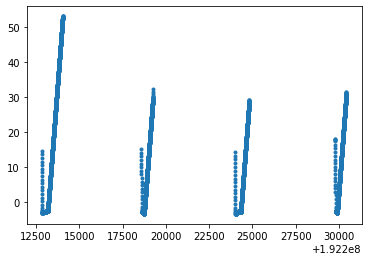

In [2]:
plt.plot(timeMKF,elevMKF, '.')

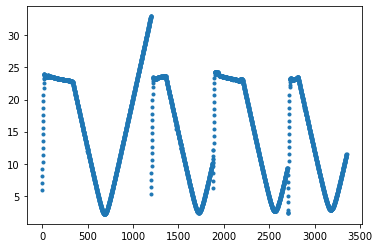

In [3]:
plt.plot(ramMKF,'.')

In [4]:
pointing_unit = np.array(tab_ni['PNTUNIT'])

In [5]:
RA = 2*np.pi-np.abs(np.arctan2(pointing_unit[:,1][startMKF:stopMKF],pointing_unit[:,0][startMKF:stopMKF]))
DEC = np.arcsin(pointing_unit[:,2][startMKF:stopMKF])
avgRA = np.mean(RA)
avgDEC = np.mean(DEC)
print(np.rad2deg(avgRA))
print(np.rad2deg(avgDEC))
# The declination matches almost exactly but the right ascension is 4.5 degrees off the expected value.

274.83978
-25.407234


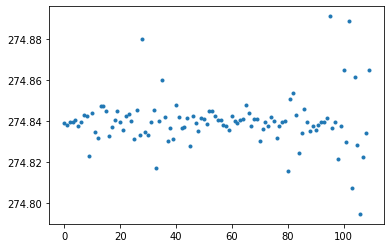

In [6]:
%matplotlib inline
#plt.plot(np.abs(np.rad2deg(DEC)),'.')
plt.plot(np.abs(np.rad2deg(RA)),'.')

In [7]:
xStar_ECI = np.mean(pointing_unit[:,0][startMKF:stopMKF])
yStar_ECI = np.mean(pointing_unit[:,1][startMKF:stopMKF])
zStar_ECI = np.mean(pointing_unit[:,2][startMKF:stopMKF])
scopeStarECI = np.array([xStar_ECI, yStar_ECI, zStar_ECI]).T
starECI = np.array([xStar_ECI, yStar_ECI, zStar_ECI]).T
starECI = starECI/np.linalg.norm(starECI)

for col in range(3):
    velocity[:,col] = velocity[:,col]/velocity_mag
    location[:,col] = location[:,col]/location_mag

pole_vec = np.cross(location,velocity)

In [37]:
## Below is a possible correction for the pointing offset in Right Ascension, which could either appear in x or y coordinates.
## This method only changes position coordinates by ~0.01 km, and it may even make it worse, so let's ignore it for now.
from scipy import optimize

def rightAscension(p):
    return (np.arctan2(p[1],p[0])-np.deg2rad(270.2))

alpha_initial_guess = [xStar_ECI, yStar_ECI]

alpha_bnds = ((xStar_ECI-0.01,xStar_ECI+0.01),(yStar_ECI-0.01,yStar_ECI+0.01))

alpha_sol = optimize.minimize(rightAscension, alpha_initial_guess, method='SLSQP', bounds=alpha_bnds)

print(alpha_sol)

# uncomment below to include the correction
#starECI = np.array([alpha_sol.x[0], alpha_sol.x[1], zStar_ECI]).T
#starECI = starECI/np.linalg.norm(starECI)
print(scopeStarECI)

     fun: -6.214050530733481
     jac: array([1.09304267, 0.07952255])
 message: 'Optimization terminated successfully'
    nfev: 6
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([ 0.06620998, -0.91006036])
[ 0.07620998 -0.90006036 -0.42904916]


#### This first method requires that we know the pole and velocity unit vectors, as well as the pointing vectors in both ECI and body frame

In [12]:
# Change of basis DCM - this is called [BN] in my notebook
M_e_to_a = np.array([location[startMKF].data,velocity[startMKF],pole_vec[startMKF]])

In [13]:
pointPrime=np.dot(M_e_to_a,starECI)
print(pointPrime)

[-0.32559    0.9443271 -0.0451   ]


In [14]:
err=0
A = np.array([[starECI[0], starECI[1], starECI[2]],
            [pole_vec[startMKF,2]*starECI[1]-pole_vec[startMKF,1]*starECI[2], pole_vec[startMKF,0]*starECI[2]-pole_vec[startMKF,2]*starECI[0], pole_vec[startMKF,1]*starECI[0]-pole_vec[startMKF,0]*starECI[1]],
            [(velocity[startMKF,1]+0.1)*starECI[2]-(velocity[startMKF,2]+err)*starECI[1], (velocity[startMKF,2]+err)*starECI[0]-(velocity[startMKF,0]+err)*starECI[2], (velocity[startMKF,0]+err)*starECI[1]-(velocity[startMKF,1]+err)*starECI[0]]])

In [15]:
rECI = np.linalg.solve(A,pointPrime)
rECI = rECI/np.linalg.norm(rECI)
print(RorbitCalc*rECI)
print(location_mag[startMKF]*location[startMKF].data)

[-4135.09754821  3882.60655511 -3743.98017689]
[-4546.0293  3709.7866 -3431.5852]


In [16]:
## total radial error in km
np.linalg.norm(location_mag[startMKF]*location[startMKF].data-RorbitCalc*rECI)

544.3548934943119

In [13]:
rECI_list = []
for i in range(len(location[startMKF:stopMKF])):
    #two calculations in each loop through the data
    M_e_to_a = np.array([location[startMKF+i].data,velocity[startMKF+i],pole_vec[startMKF+i]])
    pointPrime=np.dot(M_e_to_a,starECI)
    
    A = np.array([[starECI[0], starECI[1], starECI[2]],
            [pole_vec[startMKF+i,2]*starECI[1]-pole_vec[startMKF+i,1]*starECI[2], pole_vec[startMKF+i,0]*starECI[2]-pole_vec[startMKF+i,2]*starECI[0], pole_vec[startMKF+i,1]*starECI[0]-pole_vec[startMKF+i,0]*starECI[1]],
            [velocity[startMKF+i,1]*starECI[2]-velocity[startMKF+i,2]*starECI[1], velocity[startMKF+i,2]*starECI[0]-velocity[startMKF+i,0]*starECI[2], velocity[startMKF+i,0]*starECI[1]-velocity[startMKF+i,1]*starECI[0]]])
    rECI_i = np.linalg.solve(A,pointPrime)
    rECI_i = rECI_i/np.linalg.norm(rECI_i)
    rECI_list.append(rECI_i)
rECI_list = RorbitCalc*np.array(rECI_list)

83.16695308685303


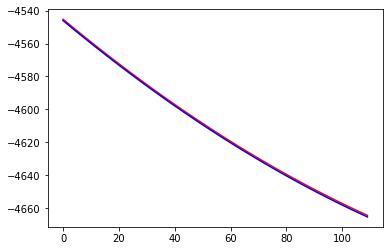

In [14]:
%matplotlib inline
plt.plot(rECI_list[:,0],'r')
plt.plot(location_mag[startMKF:stopMKF]*locationX[startMKF:stopMKF],'b')
residualsSqured=(rECI_list[:,0]-location_mag[startMKF:stopMKF]*locationX[startMKF:stopMKF])**2
RSS=sum(residualsSqured)
print(RSS)

17.752650260925293


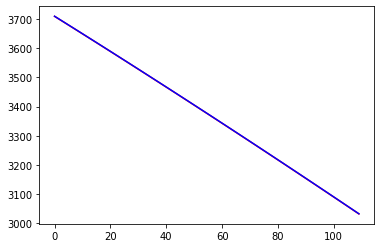

In [15]:
plt.plot(rECI_list[:,1],'r')
plt.plot(location_mag[startMKF:stopMKF]*locationY[startMKF:stopMKF],'b')
residualsSqured=(rECI_list[:,1]-location_mag[startMKF:stopMKF]*locationY[startMKF:stopMKF])**2
RSS=sum(residualsSqured)
print(RSS)

46.9534786939621


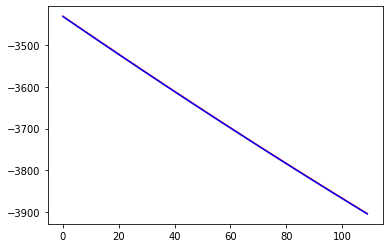

In [16]:
plt.plot(rECI_list[:,2],'r')
plt.plot(location_mag[startMKF:stopMKF]*locationZ[startMKF:stopMKF],'b')
residualsSqured=(rECI_list[:,2]-location_mag[startMKF:stopMKF]*locationZ[startMKF:stopMKF])**2
RSS=sum(residualsSqured)
print(RSS)

#### This method calculates position simply from r=velocityXpole_vec. It is less accurate than the first method but more accurate than the method below.

In [17]:
position=np.cross(velocity,pole_vec)
crossPosition = []
for row in range(len(position)):
    crossPosition.append(list(position[row]*RorbitCalc))
crossPosition=np.array(crossPosition)

131.35938048362732


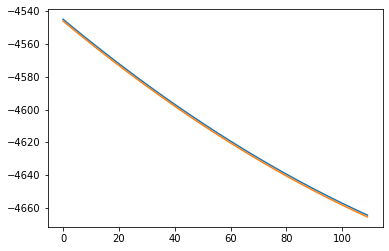

In [18]:
plt.plot(crossPosition[startMKF:stopMKF,0])
plt.plot(location_mag[startMKF:stopMKF]*locationX[startMKF:stopMKF])
residualsSqured=(crossPosition[startMKF:stopMKF,0]-location_mag[startMKF:stopMKF]*locationX[startMKF:stopMKF])**2
RSS=sum(residualsSqured)
print(RSS)

169.74483692646027


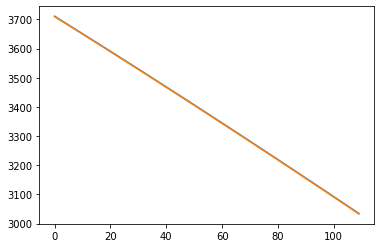

In [19]:
plt.plot(crossPosition[startMKF:stopMKF,1])
plt.plot(location_mag[startMKF:stopMKF]*locationY[startMKF:stopMKF])
residualsSqured=(crossPosition[startMKF:stopMKF,1]-location_mag[startMKF:stopMKF]*locationY[startMKF:stopMKF])**2
RSS=sum(residualsSqured)
print(RSS)

388.46430706977844


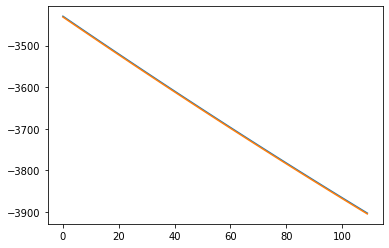

In [20]:
plt.plot(crossPosition[startMKF:stopMKF,2])
plt.plot(location_mag[startMKF:stopMKF]*locationZ[startMKF:stopMKF])
residualsSqured=(crossPosition[startMKF:stopMKF,2]-location_mag[startMKF:stopMKF]*locationZ[startMKF:stopMKF])**2
RSS=sum(residualsSqured)
print(RSS)

#### The method below uses a known pole vector and known pointing vectors in both coordinate frames. It requires the least inputs, but it is also the least accurate, likely because of NICER's 5 degree offset.

In [8]:
rECI2_list = []
for i in range(len(location[startMKF:stopMKF])):
    #two calculations in each loop through the data
    M_e_to_a = np.array([location[startMKF+i].data,velocity[startMKF+i],pole_vec[startMKF+i]])
    pointPrime=np.dot(M_e_to_a,starECI)
    err=0.03
    B = np.array([[pointPrime[0], -(pole_vec[startMKF,2]+err)*pointPrime[1], (pole_vec[startMKF,1]+err)*pointPrime[1]],
              [(pole_vec[startMKF,2]+err)*pointPrime[1], pointPrime[0], -(pole_vec[startMKF,0]+err)*pointPrime[1]],
               [-pointPrime[1]*(pole_vec[startMKF,1]+err), (pole_vec[startMKF,0]+err)*pointPrime[1], pointPrime[0]]])
    C = np.array([[starECI[0]-pole_vec[startMKF,0]*pointPrime[2]],
              [starECI[1]-pole_vec[startMKF,1]*pointPrime[2]],
              [starECI[2]-pole_vec[startMKF,2]*pointPrime[2]]])
    
    rECI2_i = np.linalg.solve(B,C)
    x = float(rECI2_i[0])
    y = float(rECI2_i[1])
    z = float(rECI2_i[2])
    rECI2_i = [x,y,z]/np.linalg.norm([x,y,z])
    rECI2_list.append(rECI2_i)
rECI2_list = RorbitCalc*np.array(rECI2_list)

60033743.1063578


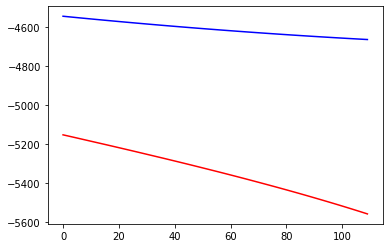

In [9]:
plt.plot(rECI2_list[:,0],'r')
plt.plot(location_mag[startMKF:stopMKF]*locationX[startMKF:stopMKF],'b')
residualsSqured=(rECI2_list[:,0]-location_mag[startMKF:stopMKF]*locationX[startMKF:stopMKF])**2
RSS=sum(residualsSqured)
print(RSS)

13016643.288609767


328.78384142653704

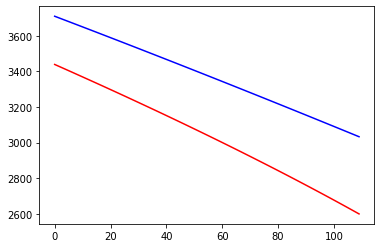

In [10]:
plt.plot(rECI2_list[:,1],'r')
plt.plot(location_mag[startMKF:stopMKF]*locationY[startMKF:stopMKF],'b')
residualsSqured=(rECI2_list[:,1]-location_mag[startMKF:stopMKF]*locationY[startMKF:stopMKF])**2
RSS=sum(residualsSqured)
print(RSS)
np.sqrt(residualsSqured[50])

69074912.52756411


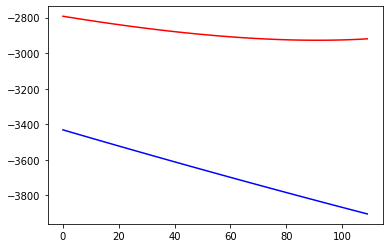

In [11]:
plt.plot(rECI2_list[:,2],'r')
plt.plot(location_mag[startMKF:stopMKF]*locationZ[startMKF:stopMKF],'b')
residualsSqured=(rECI2_list[:,2]-location_mag[startMKF:stopMKF]*locationZ[startMKF:stopMKF])**2
RSS=sum(residualsSqured)
print(RSS)

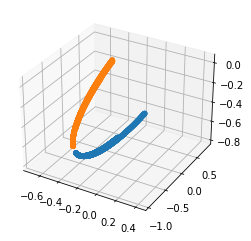

In [17]:
from mpl_toolkits import mplot3d
%matplotlib inline
fig=plt.figure()
ax=plt.axes(projection='3d')
ax.scatter3D(velocity[:,0],velocity[:,1],velocity[:,2])
ax.scatter3D(location[:,0],location[:,1],location[:,2])